In [1]:
import sys
sys.path.append("..")

import time
import pprint
import numpy as np
from tqdm import tqdm
import multiprocessing
from sympy import Symbol
import matplotlib.pyplot as plt
from utils.plot_utils import set_fontsize
from optical_bloch.utils.general import flatten
from optical_bloch import Hamiltonian, Dissipator, BlochEquations
from multi_helper_funcs import multi_solve_ode, multi_solve_ode_integrate_excited

## Approximation of J=0, J=1, J'=1 system with hyperfine splittings

In [2]:
E0 = Symbol(u'E0', real = True)
E1 = Symbol(u'E1', real = True)
E2 = Symbol(u'E2', real = True)
Ee = Symbol(u'Ee', real = True)

ωl = Symbol(u'ωl', real = True)
Ωl = Symbol(u'Ωl', real = True)
ωμ = Symbol(u'ωμ', real = True)
Ωμ = Symbol(u'Ωμ', real = True)

Δl = Symbol(u'Δl', real = True)
Δμ = Symbol(u'Δμ', real = True)

a = Symbol('a', real = True)
b = Symbol('b', real = True)
α = Symbol('α', real = True)
β = Symbol('β', real = True)

Plx = Symbol('Plx', real = True)
Plz = Symbol('Plz', real = True)
Pμx = Symbol('Pμx', real = True)
Pμz = Symbol('Pμz', real = True)

Δ = Symbol('Δ', real = True)

In [3]:
ham = Hamiltonian(10)
ham.addEnergies([E0, E0, E0, E1, E1, E1, E2, E2, E2, Ee])

# z couplings
ham.addCoupling(4,9,a*Ωl*Plz, ωl)
ham.addCoupling(7,9,b*Ωl*Plz, ωl)

ham.addCoupling(0,3,α*Ωμ*Pμz, ωμ)
ham.addCoupling(1,4,α*Ωμ*Pμz, ωμ)
ham.addCoupling(2,5,α*Ωμ*Pμz, ωμ)
ham.addCoupling(0,6,β*Ωμ*Pμz, ωμ)
ham.addCoupling(1,7,β*Ωμ*Pμz, ωμ)
ham.addCoupling(2,8,β*Ωμ*Pμz, ωμ)

# # x couplings
ham.addCoupling(3,9,a*Ωl*Plx, ωl)
ham.addCoupling(5,9,a*Ωl*Plx, ωl)

ham.addCoupling(6,9,b*Ωl*Plx, ωl)
ham.addCoupling(8,9,b*Ωl*Plx, ωl)

ham.addCoupling(0,4,α*Ωμ*Pμx, ωμ)
ham.addCoupling(2,4,α*Ωμ*Pμx, ωμ)

ham.addCoupling(0,7,β*Ωμ*Pμx, ωμ)
ham.addCoupling(2,7,β*Ωμ*Pμx, ωμ)

ham.addCoupling(1,3,α*Ωμ*Pμx, ωμ)
ham.addCoupling(1,5,α*Ωμ*Pμx, ωμ)

ham.addCoupling(1,6,β*Ωμ*Pμx, ωμ)
ham.addCoupling(1,8,β*Ωμ*Pμx, ωμ)

ham.eqnTransform()
ham.defineZero(Ee)
for _ in range(3,9):
    ham.defineStateDetuning(_,9,Δl)
    
for _ in [(0,3), (1,4), (2,5), (0,6), (1,7), (2,8), (0,4), (2,4), (0,7), (2,7), (1,3), (1,5), (1,6), (1,8)]:
    ham.defineStateDetuning(*_,Δμ)

In [4]:
Γ21 = Symbol(u'Γ21', real = True)
dis = Dissipator(10)
dis.addDecay(9,3,Γ21/6)
dis.addDecay(9,4,Γ21/6)
dis.addDecay(9,5,Γ21/6)
dis.addDecay(9,6,Γ21/6)
dis.addDecay(9,7,Γ21/6)
dis.addDecay(9,8,Γ21/6)

In [5]:
ham.hamiltonian

Matrix([
[                          E0,                            0,                            0,  -Pμz*Ωμ*α*exp(1.0*I*t*ωμ)/2,  -Pμx*Ωμ*α*exp(1.0*I*t*ωμ)/2,                            0,  -Pμz*Ωμ*β*exp(1.0*I*t*ωμ)/2,  -Pμx*Ωμ*β*exp(1.0*I*t*ωμ)/2,                            0,                           0],
[                           0,                           E0,                            0,  -Pμx*Ωμ*α*exp(1.0*I*t*ωμ)/2,  -Pμz*Ωμ*α*exp(1.0*I*t*ωμ)/2,  -Pμx*Ωμ*α*exp(1.0*I*t*ωμ)/2,  -Pμx*Ωμ*β*exp(1.0*I*t*ωμ)/2,  -Pμz*Ωμ*β*exp(1.0*I*t*ωμ)/2,  -Pμx*Ωμ*β*exp(1.0*I*t*ωμ)/2,                           0],
[                           0,                            0,                           E0,                            0,  -Pμx*Ωμ*α*exp(1.0*I*t*ωμ)/2,  -Pμz*Ωμ*α*exp(1.0*I*t*ωμ)/2,                            0,  -Pμx*Ωμ*β*exp(1.0*I*t*ωμ)/2,  -Pμz*Ωμ*β*exp(1.0*I*t*ωμ)/2,                           0],
[-Pμz*Ωμ*α*exp(-1.0*I*t*ωμ)/2, -Pμx*Ωμ*α*exp(-1.0*I*t*ωμ)/2,                            

In [6]:
from sympy import nsimplify

In [7]:
ham.transformed = nsimplify(ham.transformed)
ham.transformed = ham.transformed.subs(-E1+E2, Symbol('Δ', real = True))
ham.transformed

Matrix([
[   -Δl - Δμ,           0,           0, -Pμz*Ωμ*α/2, -Pμx*Ωμ*α/2,           0, -Pμz*Ωμ*β/2, -Pμx*Ωμ*β/2,           0,           0],
[          0,    -Δl - Δμ,           0, -Pμx*Ωμ*α/2, -Pμz*Ωμ*α/2, -Pμx*Ωμ*α/2, -Pμx*Ωμ*β/2, -Pμz*Ωμ*β/2, -Pμx*Ωμ*β/2,           0],
[          0,           0,    -Δl - Δμ,           0, -Pμx*Ωμ*α/2, -Pμz*Ωμ*α/2,           0, -Pμx*Ωμ*β/2, -Pμz*Ωμ*β/2,           0],
[-Pμz*Ωμ*α/2, -Pμx*Ωμ*α/2,           0,         -Δl,           0,           0,           0,           0,           0, -Plx*a*Ωl/2],
[-Pμx*Ωμ*α/2, -Pμz*Ωμ*α/2, -Pμx*Ωμ*α/2,           0,         -Δl,           0,           0,           0,           0, -Plz*a*Ωl/2],
[          0, -Pμx*Ωμ*α/2, -Pμz*Ωμ*α/2,           0,           0,         -Δl,           0,           0,           0, -Plx*a*Ωl/2],
[-Pμz*Ωμ*β/2, -Pμx*Ωμ*β/2,           0,           0,           0,           0,      Δ - Δl,           0,           0, -Plx*b*Ωl/2],
[-Pμx*Ωμ*β/2, -Pμz*Ωμ*β/2, -Pμx*Ωμ*β/2,           0,           0,  

In [8]:
%%time
bloch = BlochEquations(10, dis.density_matrix, ham.transformed, dis.dissipator)

Wall time: 3min 18s


In [9]:
y0 = np.zeros([ham.levels, ham.levels], dtype = complex)
for _ in range(3,9):
    y0[_,_] = 1/6
y0 = y0.flatten()

In [10]:
Γ21_val = 1
replacements = [(Δl, 0),
                (Δμ, 0),
                (a, 1),
                (b, 1),
                (α, 1/3),
                (β, 2/3),
                (Ωl, 1*Γ21_val),
                (Ωμ, 1*Γ21_val),
                (Plz, 1/np.sqrt(2)),
                (Plx, 1/np.sqrt(2)),
                (Pμz, 1/np.sqrt(2)),
                (Pμx, 1/np.sqrt(2)),
                (Δ, 0.12*Γ21_val),
                (Γ21, Γ21_val)]

In [11]:
%%time
sol = bloch.solveNumeric(replacements, [0,300], y0, method = 'BDF')

Wall time: 15.3 s


1.0681404436709556

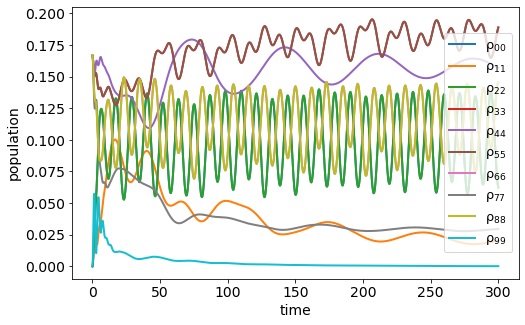

In [12]:
r = np.einsum("iij->ij", sol.y.reshape(bloch.levels, bloch.levels,sol.t.size)).real

fig, ax = plt.subplots(figsize = (8,5))
for _ in range(len(r)):
    ax.plot(sol.t, r[_], label = f'ρ$_{{{_}{_}}}$', lw = 2)

ax.legend(fontsize = 13)
ax.set_xlabel('time')
ax.set_ylabel('population')

set_fontsize(ax, 14)

np.trapz(np.sum(sol.y[[-1]].real, axis = 0), sol.t)

1.0681404436709556

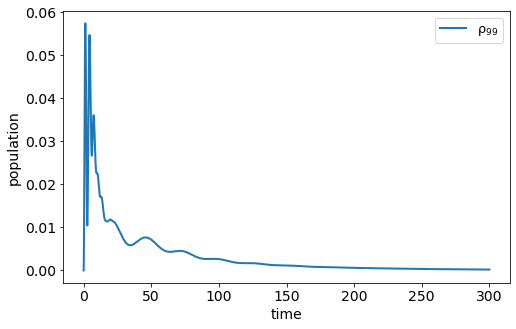

In [13]:
r = np.einsum("iij->ij", sol.y.reshape(bloch.levels, bloch.levels,sol.t.size)).real

fig, ax = plt.subplots(figsize = (8,5))
for _ in [9]:
    ax.plot(sol.t, r[_], label = f'ρ$_{{{_}{_}}}$', lw = 2)

ax.legend(fontsize = 13)
ax.set_xlabel('time')
ax.set_ylabel('population')

set_fontsize(ax, 14)

np.trapz(np.sum(sol.y[[-1]].real, axis = 0), sol.t)

## Automatically transfer to Julia, kind of hacky currently

In [14]:
# import julia
# julia.install()

In [11]:
from julia import Main

In [12]:
nprocs = 12
Main.eval(f"""
using BenchmarkTools
using Distributed
""")

if Main.eval("nprocs()") < nprocs:
    Main.eval(f"addprocs({nprocs}-nprocs())")

if Main.eval("nprocs()") > nprocs:
    addprocs({nprocs})
    procs = Main.eval("procs()")
    procs = procs[nprocs:]
    Main.eval(f"rmprocs({procs})")

Main.eval("""
@everywhere begin
    using ModelingToolkit
    using LinearAlgebra
    using Trapz
    using DifferentialEquations
    using ModelingToolkit
end
""")

    
Main.eval("procs()")

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [16]:
from sympy import MutableDenseMatrix, conjugate, Function, Symbol

t = Symbol('t', real = True)

hamiltonian_symbols = ham.transformed.free_symbols
dissipator_symbols = dis.dissipator.free_symbols
dissipator_symbols = set([d for d in dissipator_symbols if str(d)[0] not in ['ρ', 't']])

for s in list(hamiltonian_symbols) + list(dissipator_symbols):
    Main.eval(f"""
                @everywhere @parameters {str(s)}
                tmp = 0
            """);


lx, ly = ham.transformed.shape
Main.eval(f"""
            @everywhere begin
            H = zeros(Num, {lx}, {ly})
            L = zeros(Num, {lx}, {ly})
            @variables t ρ[1:{lx},1:{ly}](t)
            @parameters icomplex
            D = Differential(t)
            tmp = 0
            end
            """);

diss = MutableDenseMatrix(dis.dissipator.copy())

for i in range(lx):
    for j in range(i,ly):
        tmp = Function(u'ρ{0}{1}'.format(chr(0x2080+i), 
                                         chr(0x2080+j)))
        tmp1 = Function(u'ρ[{0},{1}]'.format(j+1, i+1))
        diss = diss.subs(conjugate(tmp(t)), tmp1(t))
            
for i in range(lx):
    for j in range(i,ly):
        tmp = Function(u'ρ{0}{1}'.format(chr(0x2080+i), 
                                         chr(0x2080+j)))
        tmp1 = Function(u'ρ[{0},{1}]'.format(i+1, j+1))
        diss = diss.subs(tmp(t), tmp1(t))


for idx in range(1,lx+1):
    for idy in range(1,ly+1):
        hval = str(ham.transformed[idx-1,idy-1])
        dval = str(diss[idx-1, idy-1])
        dval = dval.replace('(t)', '')
        Main.eval(f"""
                @everywhere begin
                H[{idx},{idy}] = {hval}
                L[{idx},{idy}] = {dval}
                tmp = 0
                end
                """);
        
# ham_pars = ham.transformed.free_symbols

In [18]:
ham_string = ','.join([str(h) for h in hamiltonian_symbols])
diss_string = ','.join([str(d) for d in dissipator_symbols])

Main.eval(f"""
@everywhere begin
    eq = -icomplex*Symbolics.scalarize(H*ρ-ρ*H) + L
    eqns = [D(ρ[idx,idy]) ~ eq[idx,idy] for idx in 1:{lx} for idy in 1:{ly}];
    bloch = ODESystem(eqns)

    tmp = 0
end
""");

In [39]:
y0 = np.zeros([ham.levels, ham.levels], dtype = complex)
for _ in range(3,9):
    y0[_,_] = 1/6
Main.ρ_ini = y0
Main.eval("@everywhere ρ_ini = $ρ_ini")

In [40]:
Main.eval("""
    @everywhere begin
    p = [
    Ωl => 1,
    Ωμ => 1,
    Plz => 1/sqrt(2),
    Plx => 1/sqrt(2),
    Pμz => 1/sqrt(2),
    Pμx => 1/sqrt(2),
    a => 1,
    b => 1,
    α => 1/3,
    β => 2/3,
    Δ => 0.12,
    Δμ => 0,
    Δl => 0,
    Γ21 => 1,
    icomplex => im
    ]
    dim = size(ρ_ini)[1]
    u0 = [ρ[idx,idy] => ρ_ini[idx,idy] for idx in 1:dim for idy in 1:dim]
    tmp =0;
end
""");

In [51]:
Main.eval("""
@everywhere begin
    tspan = (0.0, 300.)
    prob = ODEProblem(bloch, ρ_ini, tspan, p, jac = true)
end
""");

In [1]:
Main.eval("@time sol = solve(prob, Tsit5(), abstol = 1e-10, reltol = 1e-10)");

NameError: name 'Main' is not defined

In [55]:
ut = np.array(Main.eval("sol[:]"))
dim = int(np.sqrt(ut.shape[1]))
pop_results = np.real(np.einsum('jji->ji',ut.reshape(-1,dim, dim).T))
t_array = Main.eval("sol.t") 

1.0681809716789736

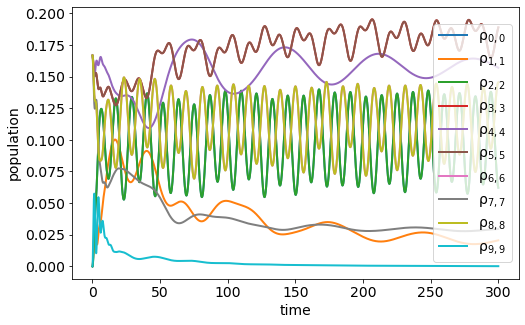

In [56]:
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ax.plot(t_array, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$")

ax.set_xlabel('time')
ax.set_ylabel('population')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

np.trapz(np.sum(pop_results[[-1]].real, axis = 0), t_array)

## Scan Ωl and Ωμ

In [57]:
Ωls = np.linspace(0,10,101)
Ωμs = np.linspace(0,10,101)
params = np.array(np.meshgrid(Ωls, Ωμs)).T.reshape(-1,2)
Main.params = params
Main.eval("@everywhere params = $params")

In [58]:
Main.eval("""
@everywhere function output_func(sol,i)
           return trapz(sol.t, [real(sol.u[j][end]) for j in 1:size(sol.u)[1]]), false
       end
""")

In [59]:
Main.eval("parameters(bloch)")

[<PyCall.jlwrap icomplex>,
 <PyCall.jlwrap α>,
 <PyCall.jlwrap β>,
 <PyCall.jlwrap Pμz>,
 <PyCall.jlwrap Pμx>,
 <PyCall.jlwrap Ωμ>,
 <PyCall.jlwrap a>,
 <PyCall.jlwrap Ωl>,
 <PyCall.jlwrap Δμ>,
 <PyCall.jlwrap Δl>,
 <PyCall.jlwrap Plx>,
 <PyCall.jlwrap Plz>,
 <PyCall.jlwrap Δ>,
 <PyCall.jlwrap b>,
 <PyCall.jlwrap Γ21>]

In [60]:
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
           remake(prob, p = [im, 1/3, 2/3, 1, 0, params[i,2], 0, params[i,1], 0, 0, 0, 1, 0.12, 1, 1])
       end
""")

In [61]:
Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [62]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true, 
            save_everystep = true; trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 1e-9, reltol = 1e-6)
sim.elapsedTime
""")

216.9848877

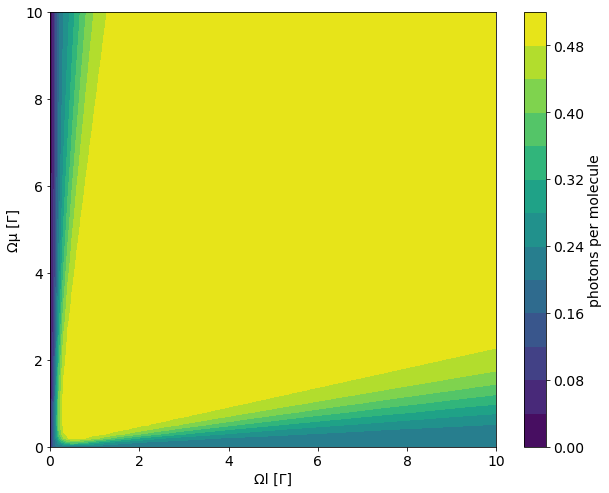

In [63]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0], params[:,1], np.array(Main.eval("sim.u")), levels = 15)

cbar = fig.colorbar(tcf)

ax.set_xlabel('Ωl [Γ]')
ax.set_ylabel(r'Ωμ [Γ]')
cbar.ax.set_ylabel('photons per molecule')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

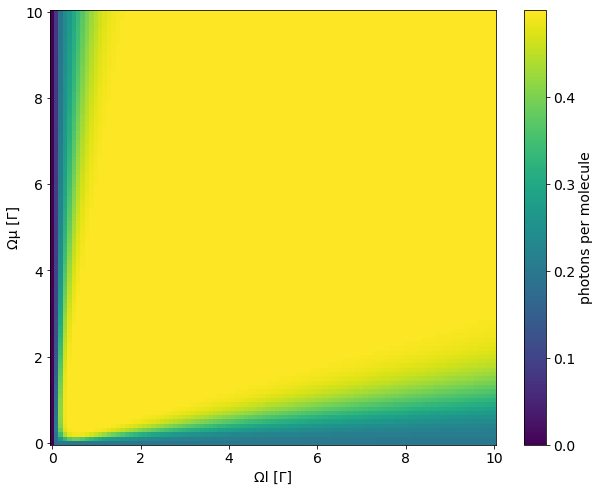

In [64]:
X, Y = np.meshgrid(Ωls, Ωμs)

fig, ax = plt.subplots(figsize = (10,8))

c = ax.pcolormesh(X, Y, np.array(Main.eval("sim.u")).reshape(-1,Ωls.size).T, shading="auto")
cbar = fig.colorbar(c)

ax.set_xlabel('Ωl [Γ]')
ax.set_ylabel('Ωμ [Γ]')
cbar.ax.set_ylabel('photons per molecule')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)